# ECS7026P Neural Networks and Deep Learning - 2022/23 : Coursework 1


    Name: Mohammed Ataaur Rahaman
    Student Number: 220843052
    email: m.a.rahaman@se22.qmul.ac.uk
    Assignment Number: Coursework 1
    Module Code: ECS6P9U/P/7026P
    Module Name: Neural Networks and Deep Learning 
    
---

**Requirements**

In [1]:
# draw Model
!conda install python-graphviz -y

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.14.0
  latest version: 23.3.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.

Retrieving notices: ...working... done


In [2]:
# Visualize layers
!pip install torchview

In [3]:
# Log progress in a pretty way
!pip install progress-table

In [4]:
# Check GPU
!nvidia-smi

Wed Apr 12 21:46:48 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.48.07    Driver Version: 515.48.07    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A40          On   | 00000000:E3:00.0 Off |                    0 |
|  0%   55C    P0   186W / 300W |      0MiB /  5067MiB |     60%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

---
#### Imports 

In [5]:
# Visualization
import matplotlib.pyplot as plt
from torchview import draw_graph
from progress_table import ProgressTable
from tqdm.auto import tqdm


# Modeling
import numpy as np
import torch
import torchvision
from torch import nn

## 1. Data Gathering & Pre-Processing

### 1.1 Data Augmentation
Training data variations are created by data Augmentation.

In [6]:
# Transformations type : https://pytorch.org/vision/main/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(), 
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


transform_train_1 = torchvision.transforms.Compose([
    torchvision.transforms.Resize((32,32)),  #resises the image so it can be perfect for our model.
    torchvision.transforms.RandomHorizontalFlip(), # FLips the image w.r.t horizontal axis
    torchvision.transforms.RandomRotation(10),     #Rotates the image to a specified angel
    torchvision.transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Performs actions like zooms, change shear angles.
    torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Set the color params
    torchvision.transforms.ToTensor(), # comvert the image to tensor so that it can work with torch
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #Normalize all the images
])
 
transform_train_2 = torchvision.transforms.Compose([
    #torchvision.transforms.Resize((32,32)),  #resises the image so it can be perfect for our model.
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomCrop(size=[32,32], padding=4),
    torchvision.transforms.RandomRotation(degrees=(-15, 15)),
    #torchvision.transforms.RandomAdjustSharpness(sharpness_factor=2),
    #torchvision.transforms.RandomResizedCrop(size=(32, 32)),
    torchvision.transforms.ToTensor(), 
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #Normalize all the images
])


stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
transform_train_3 = torchvision.transforms.Compose([
    torchvision.transforms.RandomCrop(32, padding=4, padding_mode='reflect'), 
    torchvision.transforms.RandomHorizontalFlip(), 
    torchvision.transforms.RandomRotation(degrees=(-15, 15)),
    torchvision.transforms.ToTensor(), 
    torchvision.transforms.Normalize(*stats,inplace=True)
])
transform_val_3 = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize(*stats)])

In [7]:
transform_train = transform_train_3
transform_val = transform_val_3

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_val)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
# print test and train dataset properties
trainset, testset

(Dataset CIFAR10
     Number of datapoints: 50000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: Compose(
                RandomCrop(size=(32, 32), padding=4)
                RandomHorizontalFlip(p=0.5)
                RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
                ToTensor()
                Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
            ),
 Dataset CIFAR10
     Number of datapoints: 10000
     Root location: ./data
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
            ))

### 1.2 Data Loader

In [9]:
BATCH_SIZE = 4
CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

### 1.3 Check data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


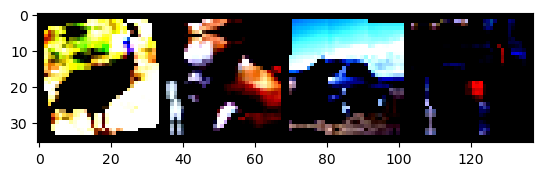

bird  dog   car   truck


In [10]:
# Code reused from Pytorch Tutorial: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{CLASSES[labels[j]]:5s}' for j in range(BATCH_SIZE)))


In [11]:
# print size of data

images, labels = next(iter(trainloader))
images.shape, labels.shape

(torch.Size([4, 3, 32, 32]), torch.Size([4]))

## 2. Model Architecture

Given below is a basic required architecture.


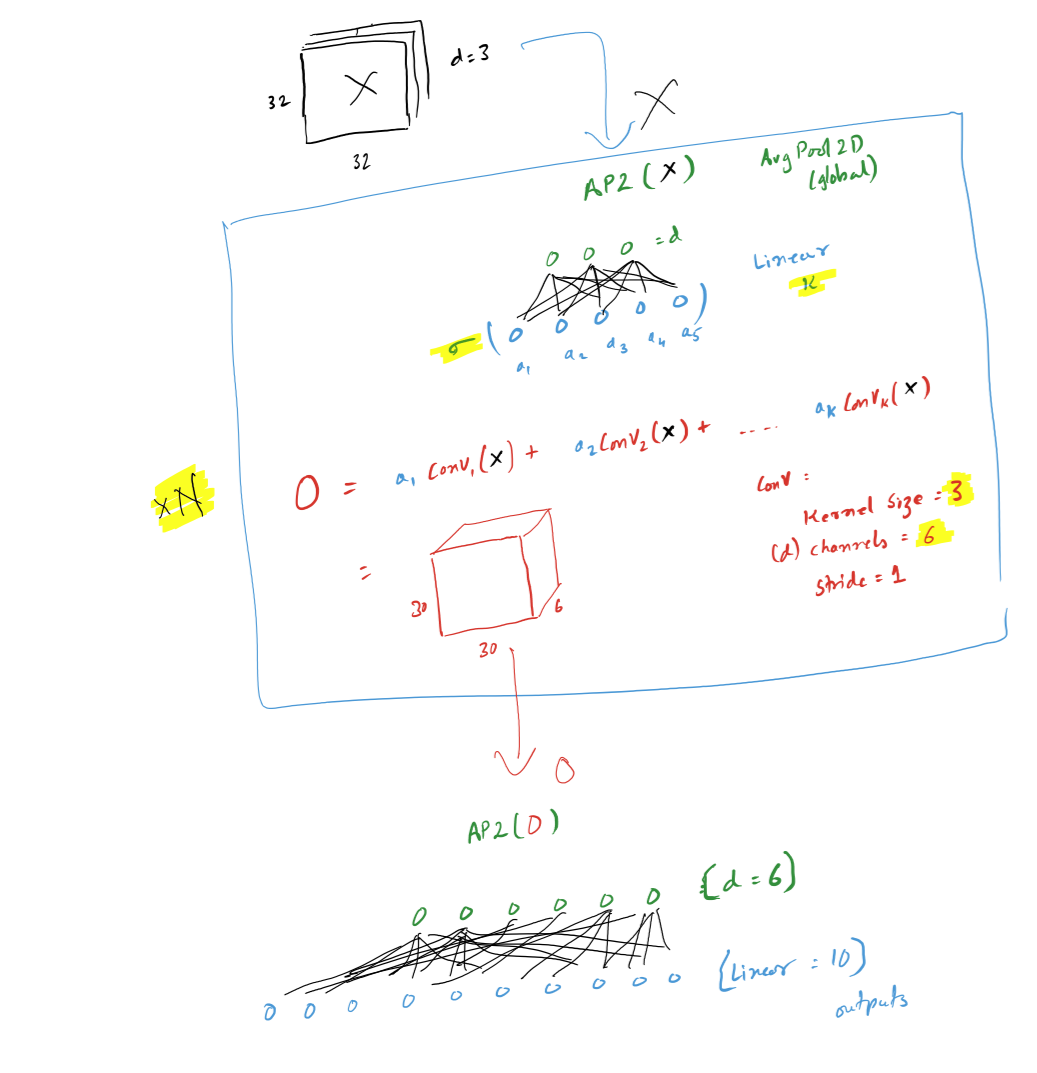

This architecture is further updated with additional parameters like dropouts, normalization etc to help aid in modeling.

In [12]:
# Parameters 

N = 2
IMG_DIM = 32
IMG_CHANNELS = 3
HIDDEN_CHANNELS = 16
HIDDEN_CONV_KERNEL = 5
STRIDE = 1

### 2.1 ConvLayer

In [13]:
class ConvLayer(nn.Sequential):

    def __init__(self, in_channels, out_channels, kernel_size):
        """
        Convolution Block.
        """
        
        super(ConvLayer, self).__init__(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=1, padding=0),
            nn.BatchNorm2d(num_features=out_channels),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            #nn.AvgPool2d(kernel_size=2, stride=2, padding=0),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            nn.Dropout2d(p=0.2),
        )

### 2.2 ConvBlock

In [14]:
class ConvBlock(nn.Module):
    def __init__(self, channels, kernel_size):
        """
        TODO
        """
            
        super(ConvBlock, self).__init__()
        
        self.conv_block = nn.Sequential(*[
            ConvLayer(in_channels=channels[i], out_channels=channels[i+1], kernel_size=kernel_size)
            for i in range(len(channels) - 1)
        ])


    def forward(self, x):
        #return self.relu(self.batch_norm(self.conv_block(x) + self.conv(x)))
        return self.conv_block(x)


### 2.3 Backbone

In [15]:
class Backbone(nn.Module):

    def __init__(self, channels, kernel_size=HIDDEN_CONV_KERNEL, k=5, debug=False):
        """
        Backbone Block, having K ConvBlocks returning weighted sum. weights calculated using linear transformation of adaptiveAvgPool (spatial average pool).
        """
            
        super(Backbone, self).__init__()

        # Boolean to print debug logs.
        self.debug = debug

        self.spaitial_average_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))

        self.mlp = nn.Sequential(
            nn.Linear(in_features=channels[0], out_features=k, bias=True),   # Question, can this be MLP?
            #nn.Tanh(),
            #nn.LeakyReLU(),
            # nn.Linear(in_features=k, out_features=k, bias=True),  
            #nn.ReLU(),
            nn.Sigmoid(),      # Non Linear Activation
            #nn.BatchNorm1d(k),
        )

        self.parallel_conv_blocks = nn.ModuleList([
            ConvBlock(channels=channels, kernel_size=kernel_size)
            for _ in range(k)
        ])

        self.batch_norm = nn.BatchNorm2d(num_features=channels[-1])

    def forward(self, x):
        sap_out = self.spaitial_average_pool(x).reshape(x.shape[0], -1)
        if self.debug: print(f"{sap_out.shape=}")

        g_out = self.mlp(sap_out)
        if self.debug: print(f"{g_out.shape=}")
        if self.debug: print(f"{g_out=}")

        outs = list()
        for a, conv_block in zip(g_out.transpose(0, 1), self.parallel_conv_blocks):
        #for conv2d in self.conv2ds:
            c_out = conv_block(x)
            if self.debug: print(f"{c_out.shape=}")
            if self.debug: print(f"{a.shape=}, \n{a=}")

            out = a.reshape(x.shape[0], 1, 1, 1)*c_out
            if self.debug: print(f"{out.shape=}")
            outs.append(out)
            #outs.append(c_out)

        out = sum(outs)
        if self.debug: print(f"{out.shape=}")

        out = self.batch_norm(out)
        if self.debug: print(f"batch_{out.shape=}")

        return out

### 2.4 Classifier

In [16]:
class Classifier(nn.Module):
    
    def __init__(self, in_features, out_features, debug=True):
        """
        Classifer, to classify the CIFAR 10 dataset. it has SpatialAveragePool and an linear layer.
        """
        
        super(Classifier, self).__init__()
        self.debug = debug
        
        self.spaitial_average_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        
        self.mlp = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=in_features * 2 // 3, bias=True),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(in_features=in_features * 2 // 3, out_features=in_features // 3, bias=True),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(in_features=in_features // 3, out_features=len(CLASSES), bias=True),
            #nn.Linear(in_features=in_features, out_features=out_features, bias=True),
        )
        
    def forward(self, x):
        
        f = self.spaitial_average_pool(x).reshape(x.shape[0], -1)
        if self.debug: print(f"Classifier: {f.shape=}")

        out = self.mlp(f)
        if self.debug: print(f"Classifier: {out.shape=}")

        return out

### 2.5 Model

In [17]:
class Model(nn.Module):
    
    def __init__(self, channels, Ks, kernel_size=HIDDEN_CONV_KERNEL, n=N, debug=False):
        """
        Model, having N Backbones and a classifer.
        """
        super(Model, self).__init__()
        
        self.debug = debug   # Boolean to print debug logs.
        self.Ks = Ks
        self.channels = channels
        self.n = n

        self.backbones = nn.Sequential(*[
            Backbone(
                channels=self.channels[i],
                #self.channels[i], 
                #out_channels=self.channels[i+1], 
                kernel_size=kernel_size, 
                k=self.Ks[i], 
                debug=debug
            ) 
            for i in range(self.n)
        ])
        
        self.classifier = Classifier(in_features=self.channels[-1][-1], out_features=len(CLASSES), debug=debug)

    @property
    def device(self):
        return next(self.parameters()).device
    
    def set_debug(self, debug=True):
        
        self.debug = debug
        for backbone in self.backbones:
            backbone.debug = debug
        self.classifier.debug = debug

    def forward(self, x):
        x = self.backbones(x)
        out = self.classifier(x)
        return out

## 3 Trainer

In [18]:
class Trainer:
    
    def __init__(self, model, criterion, optimizer, scheduler, trainloader, testloader, logs_per_epoch=4, grad_clip=None) -> None:
        """
        Trainer to help in training of the model.
        """
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.grad_clip = grad_clip
        
        self.epochs = 0
        self.log_step = len(trainloader) // logs_per_epoch if logs_per_epoch is not None else None

        self.trainloader = trainloader
        self.testloader = testloader
        
        self.lrs = list()
        self.losses = list()
        self.val_losses = list()
        self.batch_losses = list()

        self.train_accuracy = list()
        self.val_accuracy = list()
        
        self.history_table = self.get_history_table()
    
    @staticmethod
    def get_history_table():
        history_table = ProgressTable(
            columns=["Epoch", "LR", "train_loss", "test_loss", "train_accuracy", "test_accuracy"],
            # Default arguments:
            refresh_rate=10,
            num_decimal_places=8,
            default_column_width=12,
            default_column_alignment="center",
            print_row_on_update=True,
            reprint_header_every_n_rows=10,
            custom_format=None,
            embedded_progress_bar=False,
            table_style="double",  #['ascii', 'ascii_bare', 'normal', 'bare', 'bold', 'double', 'round']
        )
        history_table.add_column("Epoch", width=4)
        history_table.add_column("train_loss", color=["BRIGHT", "BLUE"])
        history_table.add_column("test_loss", color=["BRIGHT", "YELLOW"])
        history_table.add_column("train_accuracy",color=["BRIGHT", "BLUE"])
        history_table.add_column("test_accuracy", color=["BRIGHT", "YELLOW"])
        return history_table
    
    def train(self, epochs=3, use_gpu=False):
        
        for epoch in range(self.epochs, self.epochs + epochs):  # loop over the dataset multiple times

            batch_losses = list()
            running_loss = 0.0
            correct = 0
            total = 0
        
            
            # Set model to training.
            self.model.train()
            
            # Train loop
            #for i, data in self.history_table(tqdm(enumerate(self.trainloader, 0), total=len(trainloader), desc=f"Epoch {epoch + 1} ", unit="batch", leave=False, disable=True)):
            for i, (inputs, labels) in self.history_table(enumerate(self.trainloader, 0), length=len(trainloader)):
                
                # Transfer data to device.
                images, labels = images.to(model.device), labels.to(model.device)

                # Zero the parameter gradients
                self.optimizer.zero_grad()

                # Forward + backward + optimize
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                if self.grad_clip is not None: nn.utils.clip_grad_value_(self.model.parameters(), self.grad_clip)
                self.optimizer.step()
                
                # Accuracy
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                # Print statistics
                batch_losses.append(loss.item())
                running_loss += loss.item()
                if self.log_step is not None and i % self.log_step == self.log_step-1:    # print every self.log_step mini-batches
                    avg_loss = running_loss / self.log_step
                    print(f'[{epoch + 1}, {i + 1:5d}] loss: {avg_loss:.3f}')
                    running_loss = 0.0
                    self.batch_losses.append(avg_loss)

            self.losses.append(sum(batch_losses) / len(batch_losses))
            #print(f"Train Loss : {self.losses[-1]}")
            
            # Calculate accuracy
            accuracy = correct / total
            self.train_accuracy.append(accuracy)
            #print(f'Train Accuracy : {100 * accuracy:.2f} %')
            
            # Save Learning rate.
            #print(f"{self.scheduler.get_last_lr()=}")
            #print(f"{self.optimizer.param_groups[0]['lr']=}")
            self.lrs.append(self.optimizer.param_groups[0]['lr'])
            
            val_loss, val_accuracy = self.eval()
            self.scheduler.step(val_loss)
            
            #print(f"Epoch : {epoch+1:5d} | LR : {self.lrs[-1]:.8f} | Train Loss : {self.losses[-1]:.2f} | Train Accuracy : {100 * accuracy:.2f} | Test Loss : {val_loss:.2f} | Test Accuracy : {100 * val_accuracy:.2f}")
            
            # Update history_table
            self.history_table["Epoch"] = epoch+1
            self.history_table["LR"] = self.lrs[-1]
            self.history_table["train_loss"] = self.losses[-1]
            self.history_table["test_loss"] = val_loss
            self.history_table["train_accuracy"] = accuracy * 100
            self.history_table["test_accuracy"] = val_accuracy * 100
            self.history_table.next_row()
            
        self.epochs += epochs
        self.history_table.close()
        print('Finished Training')
    
    
    def eval(self):
        correct = 0
        total = 0
        losses = list()
        
        self.model.eval()
        
        # since we're not training, we don't need to calculate the gradients for our outputs
        with torch.no_grad():
            for data in self.testloader:
                images, labels = data
                if USE_GPU:
                    images = images.to('cuda')
                    labels = labels.to('cuda')

                # calculate outputs by running images through the network
                outputs = self.model(images)

                loss = self.criterion(outputs, labels)
                losses.append(loss.item())

                # the class with the highest energy is what we choose as prediction
                _, predicted = torch.max(outputs.data, 1)
                
                total += labels.size(0)
                correct += (predicted == labels).sum().item()


        val_loss = sum(losses) / len(losses)
        self.val_losses.append(val_loss)

        #print(f"Val Loss : {val_loss}")

        accuracy = correct / total
        self.val_accuracy.append(accuracy)
        #print(f'Accuracy of the network on the 10000 test images: {100 * accuracy:.2f} %')
        
        return val_loss, accuracy
    
    def plot(self):
        fig, (ax0, ax1, ax2) = plt.subplots(1, 3)
        fig.set_size_inches(15, 3)
        
        epochs_x = range(1, self.epochs+1)
        
        ax0.plot(epochs_x, self.lrs, label="LR", color='C3', lw=3, alpha=1)
        ax0.legend()
        ax0.set_yscale('log')
        ax0.set(title=f'Learning Rates', xlabel='Epoch', ylabel='Learning rate')

        X = np.linspace(1, len(self.losses), len(self.batch_losses))
        ax1.plot(X, self.batch_losses, label="Train Batches", color='C0', linestyle='dashed', lw=1, alpha=0.7)
        ax1.plot(epochs_x, self.losses, label='Train', color='C0', lw=3, alpha=1)
        ax1.plot(epochs_x, self.val_losses, label='Test', color='C1', lw=3, alpha=1)
        ax1.legend()
        ax1.set(title=f'Loss Curve', xlabel='Epoch', ylabel='Loss')
        
        ax2.plot(epochs_x, self.train_accuracy, label="Train", color='C0', lw=3, alpha=1)
        ax2.plot(epochs_x, self.val_accuracy, label="Test", color='C1', lw=3, alpha=1)
        ax2.set(title=f'Accuracy Curve', xlabel='Epoch', ylabel='Accuracy')
        ax2.legend()
        
        plt.tight_layout()
        fig.show()
    

### 3.1 Helper methods 

In [19]:
def init_weights(m):
    """
    Helps initialize weights of linear and Conv2d layers.
    """
    if type(m) == nn.Linear or type(m) == nn.Conv2d: # by checking the type we can init different layers in different ways
        torch.nn.init.xavier_uniform_(m.weight)   

In [20]:
def model_summary(model, trainloader):
    """
    A wrapper method to help debug and understand the model paramters. 
    Importantly,
        1. it does one forward pass to calculate the image dimension when propogated to N Backbone. img_size = list()
        2. uses torchview.draw_graph to visualize the model graph.
    """
    
    # Get images and labels (batch 1) for forward pass.
    images, labels = next(iter(trainloader))
    images, labels = images.to(model.device), labels.to(model.device)
    
    # Forward pass to find image dimensions from input to the final ouput of Backbone.
    img_sizes = list()
    with torch.no_grad():
        x = images
        for backbone in model.backbones:
            img_sizes_ = list()
            img_sizes_.append(x.shape[-1])
            for conv_block in backbone.parallel_conv_blocks:
                for conv in conv_block.conv_block:
                    x = conv(x)
                    img_sizes_.append(x.shape[-1])
                break # Break out of parrallel blocks
            img_sizes.append(img_sizes_)
            
    # Print Stats
    print(f"{model.channels=}")
    print(f"{model.Ks=}")
    print(f"{model.n=}")
    print(f"{img_sizes=}")
    
    # Print ConvBlock Graph
    #for idx, backbone in enumerate(model.backbones):
    conv_block = model.backbones[0].parallel_conv_blocks[0]  # All blocks in prallel (k) are same, so just printing the first.
    graph = draw_graph(conv_block, input_size=images.shape, expand_nested=True, hide_module_functions=True, hide_inner_tensors=True, roll=False)
    print(f"\nConvBlock Graph (1):")
    display(graph.visual_graph)
    
    # Print Model Graph
    graph = draw_graph(model, input_size=images.shape, expand_nested=True, hide_module_functions=True, hide_inner_tensors=True, roll=False)
    print(f"\nModel Graph:")
    display(graph.visual_graph)

## 4. Training

### 4.1 Model init

model.channels=[[3, 128, 256], [256, 512, 1028]]
model.Ks=[3, 3]
model.n=2
img_sizes=[[32, 16, 8], [8, 4, 2]]

ConvBlock Graph (1):


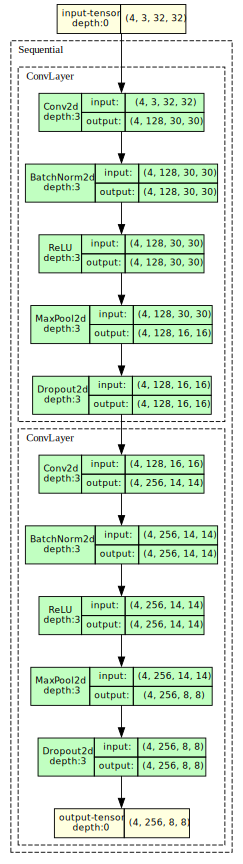


Model Graph:


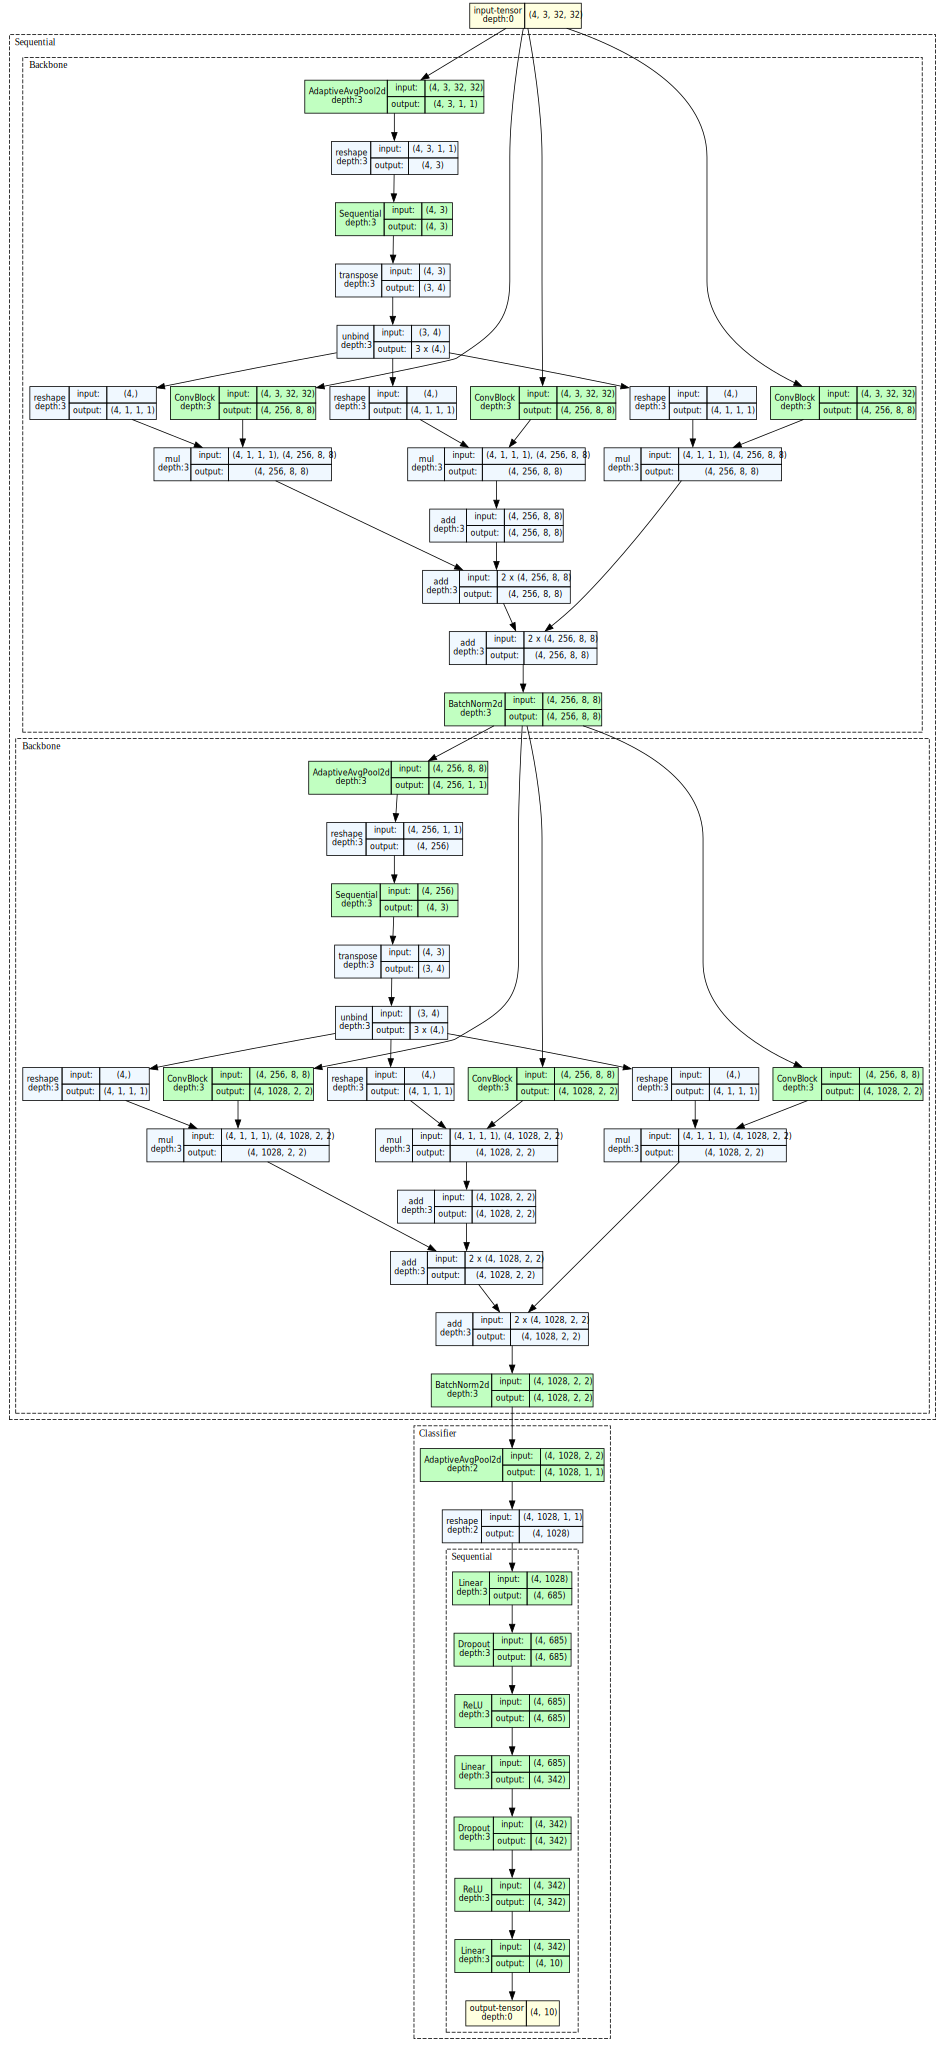

Model(
  (backbones): Sequential(
    (0): Backbone(
      (spaitial_average_pool): AdaptiveAvgPool2d(output_size=(1, 1))
      (mlp): Sequential(
        (0): Linear(in_features=3, out_features=3, bias=True)
        (1): Sigmoid()
      )
      (parallel_conv_blocks): ModuleList(
        (0): ConvBlock(
          (conv_block): Sequential(
            (0): ConvLayer(
              (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1))
              (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU()
              (3): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
              (4): Dropout2d(p=0.2, inplace=False)
            )
            (1): ConvLayer(
              (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
              (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU()
              (3): MaxPool2d(kernel_size=2, stride=

In [21]:
# Init model

IMG_DIM = 32
IMG_CHANNELS = 3
USE_GPU = True


# K = 5
# HIDDEN_CHANNELS = 16
HIDDEN_CONV_KERNEL = 3
STRIDE = 1

# channels = [IMG_CHANNELS, 16, 32, 64, 64] #20, 25, 30]
# channels = [IMG_CHANNELS, 4, 8, 16, ]
# channels = [IMG_CHANNELS, 5, 7, 9, 11, 13]
#channels = [IMG_CHANNELS, 16, 64, 256]#, 512, 1028] 
#channels = [[IMG_CHANNELS, 16, 64], [64, 256, 1028]]
channels = [[IMG_CHANNELS, 128, 256], [256, 512, 1028]]
#channels = [[IMG_CHANNELS, 3]]#, [256, 512, 1028]]
#channels = [[IMG_CHANNELS, 4, 8], [8, 16, 32], [32, 64, 128], [128, 256, 512], [512, 1024, 1024]]
#channels = [[IMG_CHANNELS, 128]]#, 256], [256, 512, 1028]]
N = len(channels)
Ks = [3] * N
#Ks = [3, 2]

model = Model(
    Ks=Ks,
    channels=channels,
    kernel_size=HIDDEN_CONV_KERNEL, 
    n=N, 
    debug=True
)

model.apply(init_weights)
if USE_GPU: model.to('cuda')
model.set_debug(False)

model_summary(model=model, trainloader=trainloader)
model

### 4.2 Loss Function

In [22]:
# Cross Entropy loss is used for classification problem
criterion = nn.CrossEntropyLoss()

### 4.3 Optimzer

In [23]:
# Init optimizer 
WEIGHT_DECAY = 1e-4 #1e-4 #0.05 # 0.15
LR = 1e-3

optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

### 4.4 Learning Rate Schedulers

In [24]:
def visualise_lr(scheduler, epochs = 20):
    """
    Method to help visualize the Learning rate.
    """
    lrs_ = list()
    values = list(range(10, 0, -1)) + list(range(0, 20)) + [10]*5 + list(range(10, 0, -1)) + list(range(0, 10)) + list(range(10, 0, -1)) + list(range(0, 10)) + list(range(10, 0, -1))
    for i in range(epochs):
        #for j in range(len(trainloader)):
        optimizer.step()
        scheduler.step(values[i])
        #scheduler.step()
        #lrs_.append(scheduler.get_last_lr())
        lrs_.append(optimizer.param_groups[0]['lr'])

    fig, ax = plt.subplots(1)
    ax.scatter(range(len(lrs_)), lrs_)
    ax.set_yscale('log')
    ax.set(xlabel="Epoch", ylabel="LR")
    fig.show()

    
def init_scheduler(optimizer, lr, scheduler_name):
    schedulers = dict()
    
    schedulers["constant_scheduler"] = torch.optim.lr_scheduler.ConstantLR(optimizer, factor=0.1, total_iters=20)
    schedulers["linear_scheduler"] = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.3333333333333333, end_factor=1.0, total_iters=50, last_epoch=- 1, verbose=False)
    schedulers["polynomial_scheduler"] = torch.optim.lr_scheduler.PolynomialLR(optimizer, total_iters=50, power=2.0, last_epoch=- 1, verbose=False)
    schedulers["exponential_scheduler"] = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

    schedulers["step_scheduler"] = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    schedulers["cyclic_scheduler"] = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-6, max_lr=1e-4, step_size_up=5, step_size_down=None, mode='triangular', gamma=1.0, scale_fn=None, scale_mode='cycle', cycle_momentum=False, base_momentum=0.8, max_momentum=0.9, last_epoch=- 1, verbose=False)
    schedulers["one_cycle_scheduler"] = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-2, total_steps=None, epochs=20, steps_per_epoch=len(trainloader), pct_start=0.3, anneal_strategy='cos', cycle_momentum=True, base_momentum=0.85, max_momentum=0.95, div_factor=25.0, final_div_factor=10000.0, three_phase=False, last_epoch=-1, verbose=False)    
    schedulers["reduce_on_plateau_scheduler"] = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=False)

    schedulers["sequential_scheduler"] = torch.optim.lr_scheduler.SequentialLR(optimizer, schedulers=[schedulers["polynomial_scheduler"], schedulers["cyclic_scheduler"]], milestones=[20])#, last_epoch=60)

    optimizer.param_groups[0]['lr'] = lr
    
    return schedulers[scheduler_name]

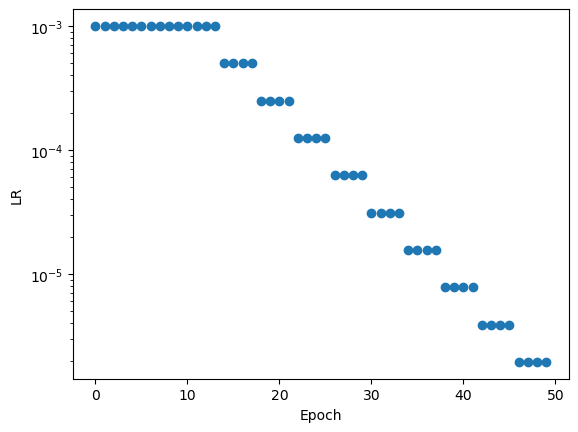

In [25]:
visualise_lr(scheduler=init_scheduler(optimizer=optimizer, lr=LR, scheduler_name="reduce_on_plateau_scheduler"), epochs=50)

### 4.5 Init Scheduler

In [26]:
scheduler = init_scheduler(optimizer=optimizer, lr=LR, scheduler_name="reduce_on_plateau_scheduler")

### 4.6 Init Trainer

In [27]:
# Init Trainer

BATCH_SIZE = 256

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)


trainer = Trainer(
    model=model, 
    criterion=criterion, 
    optimizer=optimizer, 
    scheduler=scheduler,
    logs_per_epoch=None,
    grad_clip=0.1,
    trainloader=trainloader,
    testloader=testloader,
)

### 4.7 Train

╔═══════╦══════════════╦══════════════╦══════════════╦════════════════╦═══════════════╗
║ Epoch ║      LR      ║  train_loss  ║  test_loss   ║ train_accuracy ║ test_accuracy ║
╠═══════╬══════════════╬══════════════╬══════════════╬════════════════╬═══════════════╣
║   1   ║  0.00100000  ║  1.67285563  ║  1.24388931  ║  39.31800000   ║  53.82000000  ║
║   2   ║  0.00100000  ║  1.33729585  ║  1.02478824  ║  51.75800000   ║  62.91000000  ║
║   3   ║  0.00100000  ║  1.18699138  ║  0.91194828  ║  57.65000000   ║  67.42000000  ║
║   4   ║  0.00100000  ║  1.07601561  ║  0.79503580  ║  62.12600000   ║  71.79000000  ║
║   5   ║  0.00100000  ║  1.00578276  ║  0.71604170  ║  64.47200000   ║  74.54000000  ║
║   6   ║  0.00100000  ║  0.93824592  ║  0.69765089  ║  67.02000000   ║  75.70000000  ║
║   7   ║  0.00100000  ║  0.88657073  ║  0.64547566  ║  68.94800000   ║  77.28000000  ║
║   8   ║  0.00100000  ║  0.84836828  ║  0.61220036  ║  70.49400000   ║  78.04000000  ║
║   9   ║  0.00100000  ║  0.8165

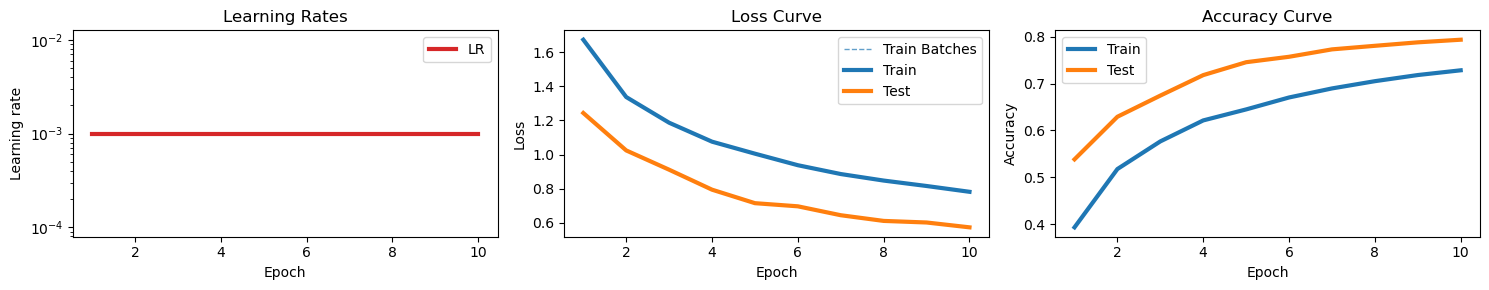

In [28]:
trainer.train(epochs=10, use_gpu=USE_GPU)
trainer.plot()

╔═══════╦══════════════╦══════════════╦══════════════╦════════════════╦═══════════════╗
║ Epoch ║      LR      ║  train_loss  ║  test_loss   ║ train_accuracy ║ test_accuracy ║
╠═══════╬══════════════╬══════════════╬══════════════╬════════════════╬═══════════════╣
║   11  ║  0.00100000  ║  0.74958148  ║  0.56395114  ║  73.99600000   ║  80.15000000  ║
║   12  ║  0.00100000  ║  0.72003375  ║  0.52256040  ║  75.14800000   ║  81.65000000  ║
║   13  ║  0.00100000  ║  0.70381843  ║  0.51277220  ║  75.50600000   ║  82.12000000  ║
║   14  ║  0.00100000  ║  0.67896103  ║  0.49957948  ║  76.39400000   ║  82.59000000  ║
║   15  ║  0.00100000  ║  0.66198935  ║  0.51070700  ║  77.22000000   ║  82.49000000  ║
║   16  ║  0.00100000  ║  0.63643680  ║  0.47664957  ║  77.74200000   ║  83.57000000  ║
║   17  ║  0.00100000  ║  0.62694002  ║  0.46976258  ║  78.48400000   ║  84.41000000  ║
║   18  ║  0.00100000  ║  0.60731059  ║  0.47317493  ║  78.91200000   ║  83.78000000  ║
║   19  ║  0.00100000  ║  0.5892

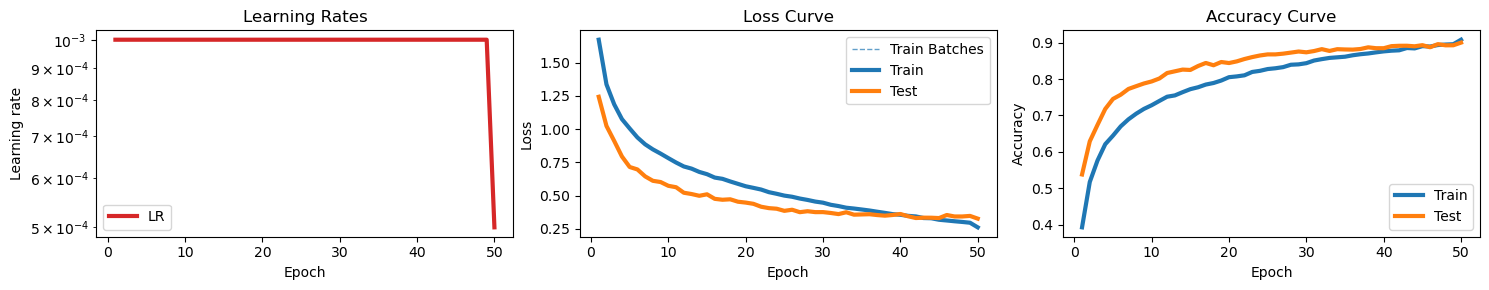

In [29]:
trainer.train(epochs=40, use_gpu=USE_GPU)
trainer.plot()

╔═══════╦══════════════╦══════════════╦══════════════╦════════════════╦═══════════════╗
║ Epoch ║      LR      ║  train_loss  ║  test_loss   ║ train_accuracy ║ test_accuracy ║
╠═══════╬══════════════╬══════════════╬══════════════╬════════════════╬═══════════════╣
║   51  ║  0.00050000  ║  0.24109897  ║  0.33164683  ║  91.53200000   ║  90.38000000  ║
║   52  ║  0.00050000  ║  0.23078884  ║  0.33046581  ║  92.02800000   ║  90.30000000  ║
║   53  ║  0.00050000  ║  0.22586781  ║  0.32316585  ║  92.06600000   ║  90.61000000  ║
║   54  ║  0.00050000  ║  0.22126319  ║  0.32905891  ║  92.22800000   ║  90.49000000  ║
║   55  ║  0.00050000  ║  0.21458660  ║  0.33257954  ║  92.49000000   ║  90.46000000  ║
║   56  ║  0.00050000  ║  0.21049795  ║  0.33440816  ║  92.57200000   ║  90.32000000  ║
║   57  ║  0.00050000  ║  0.20677393  ║  0.33114096  ║  92.90200000   ║  90.77000000  ║
║   58  ║  0.00025000  ║  0.18861580  ║  0.32694628  ║  93.36800000   ║  90.92000000  ║
║   59  ║  0.00025000  ║  0.1818

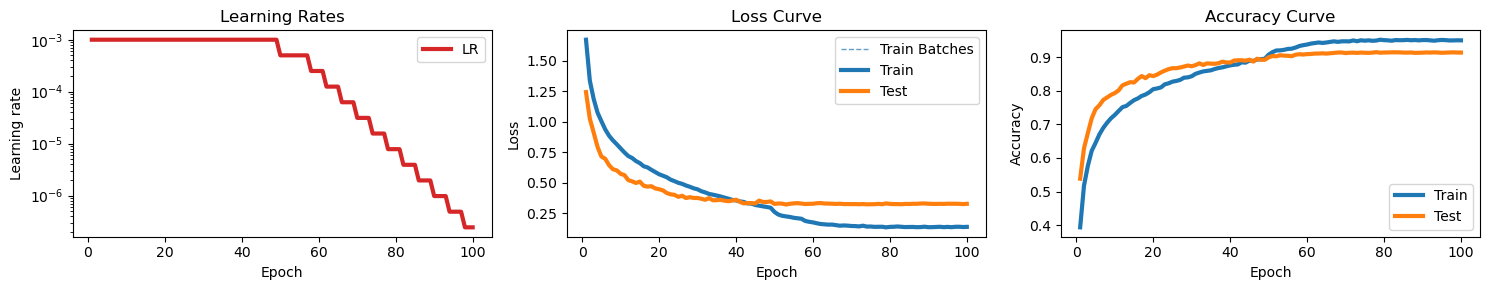

In [30]:
trainer.train(epochs=50, use_gpu=USE_GPU)
trainer.plot()

╔═══════╦══════════════╦══════════════╦══════════════╦════════════════╦═══════════════╗
║ Epoch ║      LR      ║  train_loss  ║  test_loss   ║ train_accuracy ║ test_accuracy ║
╠═══════╬══════════════╬══════════════╬══════════════╬════════════════╬═══════════════╣
║  101  ║  0.00000024  ║  0.13591437  ║  0.32865089  ║  95.33000000   ║  91.40000000  ║
║  102  ║  0.00000012  ║  0.13799151  ║  0.33071776  ║  95.23000000   ║  91.39000000  ║
║  103  ║  0.00000012  ║  0.13674617  ║  0.32887823  ║  95.30800000   ║  91.35000000  ║
║  104  ║  0.00000012  ║  0.13819741  ║  0.32836762  ║  95.19200000   ║  91.39000000  ║
║  105  ║  0.00000012  ║  0.13846731  ║  0.32708777  ║  95.17200000   ║  91.39000000  ║
║  106  ║  0.00000006  ║  0.14357582  ║  0.32991185  ║  95.00600000   ║  91.41000000  ║
║  107  ║  0.00000006  ║  0.14092210  ║  0.32857433  ║  94.98000000   ║  91.44000000  ║
║  108  ║  0.00000006  ║  0.13718781  ║  0.32708400  ║  95.21200000   ║  91.43000000  ║
║  109  ║  0.00000006  ║  0.1412

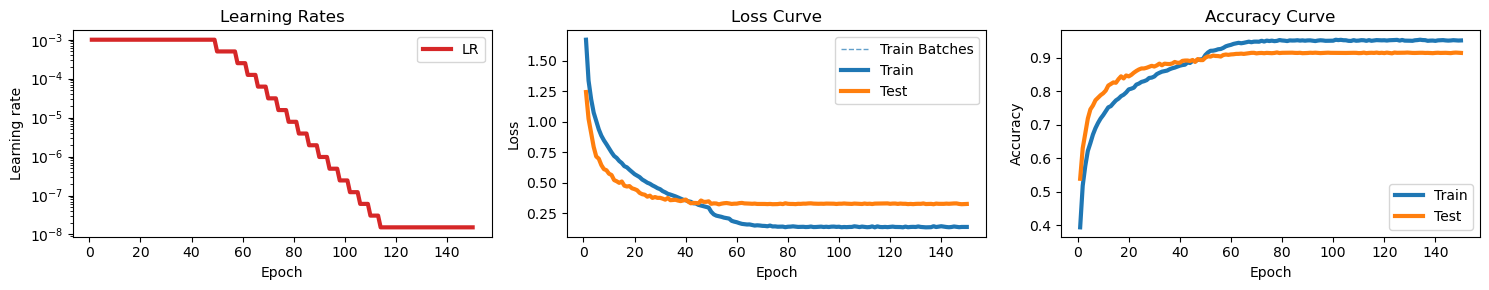

In [31]:
trainer.train(epochs=50, use_gpu=USE_GPU)
trainer.plot()

╔═══════╦══════════════╦══════════════╦══════════════╦════════════════╦═══════════════╗
║ Epoch ║      LR      ║  train_loss  ║  test_loss   ║ train_accuracy ║ test_accuracy ║
╠═══════╬══════════════╬══════════════╬══════════════╬════════════════╬═══════════════╣
║  151  ║  0.00000002  ║  0.14216284  ║  0.32971583  ║  94.98200000   ║  91.38000000  ║
║  152  ║  0.00000002  ║  0.13853827  ║  0.32881004  ║  95.18800000   ║  91.43000000  ║
║  153  ║  0.00000002  ║  0.13575855  ║  0.32927113  ║  95.30400000   ║  91.47000000  ║
║  154  ║  0.00000002  ║  0.14288397  ║  0.32600177  ║  94.97600000   ║  91.41000000  ║
║  155  ║  0.00000002  ║  0.13751891  ║  0.32747117  ║  95.13600000   ║  91.43000000  ║
║  156  ║  0.00000002  ║  0.13917342  ║  0.32859818  ║  95.05800000   ║  91.42000000  ║
║  157  ║  0.00000002  ║  0.13620285  ║  0.33081541  ║  95.13200000   ║  91.34000000  ║
║  158  ║  0.00000002  ║  0.13978028  ║  0.32903979  ║  95.15000000   ║  91.45000000  ║
║  159  ║  0.00000002  ║  0.1364

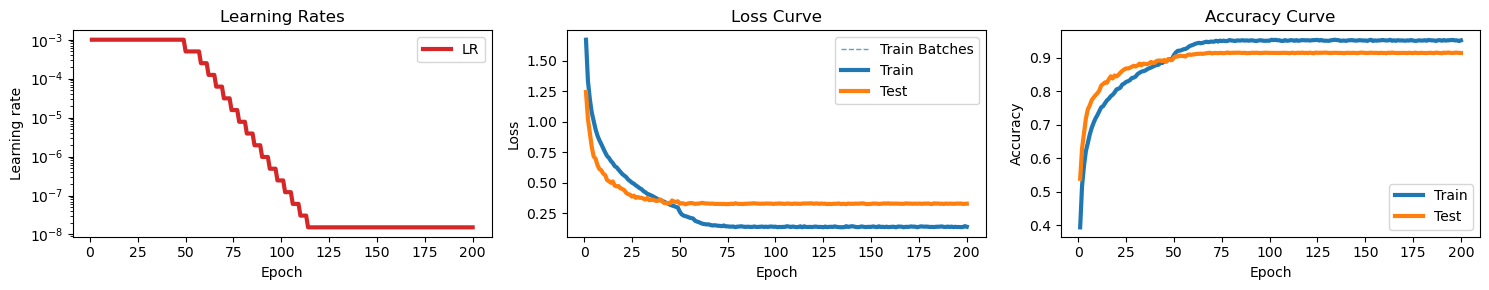

In [32]:
trainer.train(epochs=50, use_gpu=USE_GPU)
trainer.plot()

## Appendix

### ResNET Model: Experiment [Failed]

In [ ]:
# Code inspired from : https://www.kaggle.com/code/kmldas/cifar10-resnet-90-accuracy-less-than-5-min

class Conv(nn.Module):
    
    def __init__(self, in_channels, out_channels, kernel_size, pool=True):
        """
        TODO
        """
            
        super(Conv, self).__init__()
        
        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=1, padding=1),
            nn.BatchNorm2d(num_features=out_channels),
            nn.ReLU(),
            nn.Dropout2d(p=0.2),
        )
        if pool: self.conv_layer.add_module("pool", nn.MaxPool2d(kernel_size=2, stride=2, padding=0))
        
    def forward(self, x):
        return self.conv_layer(x)

    
class ResNet(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, pool=False, ):
        """
        TODO
        """
            
        super(ResNet, self).__init__()
        
        self.resnet = nn.Sequential(
            Conv(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, pool=pool),
            Conv(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, pool=pool)
        )
        
        
    def forward(self, x):
        return self.resnet(x) + x
    
class ConvBlock(nn.Module):
    def __init__(self, channels, kernel_size):
        """
        TODO
        """
            
        super(ConvBlock, self).__init__()
        
        self.conv_block = nn.Sequential(
            Conv(in_channels=channels[0], out_channels=channels[1], kernel_size=kernel_size, pool=False),
            Conv(in_channels=channels[1], out_channels=channels[2], kernel_size=kernel_size, pool=True),
            ResNet(in_channels=channels[2], out_channels=channels[2], kernel_size=kernel_size, pool=False),
            Conv(in_channels=channels[2], out_channels=channels[3], kernel_size=kernel_size, pool=True),
            Conv(in_channels=channels[3], out_channels=channels[4], kernel_size=kernel_size, pool=True),
            ResNet(in_channels=channels[4], out_channels=channels[4], kernel_size=kernel_size, pool=False),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        
    def forward(self, x):
        #return self.relu(self.batch_norm(self.conv_block(x) + self.conv(x)))
        return self.conv_block(x)


## Thank you